In [ ]:

import tensorflow as tf
import os
import sys
import cv2
import random
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sahithyagadde","key":"5e9f761f9f04fa109009af98ffa914ff"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  -----------------------------------------------  ------  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                                  428KB  2020-11-23 12:01:34           8215  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University          3MB  2020-11-23 06:03:57           4107  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                           353MB  2020-11-09 18:51:59           3339  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates           439MB  2020-11-23 21:42:31            636  
etsc9287/2020-general-election-polls                    Election, COVID, and Demographic Data by Cou

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

stage1_train.zip: Skipping, found more recently modified local copy (use --force to force download)
stage2_sample_submission_final.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_solution.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_test.zip: Skipping, found more recently modified local copy (use --force to force download)
stage2_test_final.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [ ]:
! unzip /content/stage1_train.zip -d train

Archive:  /content/stage1_train.zip
replace train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
DATA_PATH = '/content/train/'
seed = 42
random.seed = seed
np.random.seed = seed
image_ids = next(os.walk(DATA_PATH))[1]
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), )
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask
x_train=X
y_train=Y

100%|██████████| 670/670 [01:11<00:00,  9.35it/s]


In [ ]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p5)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)

u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c10)

u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1], axis=3)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

In [ ]:
def dice_acc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_acc])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

Epoch 1/30
 1/34 [..............................] - ETA: 0s - loss: 0.6590 - dice_acc: 0.2181WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - ETA: 0s - loss: 0.3771 - dice_acc: 0.3441
Epoch 00001: saving model to training_1/cp.ckpt
34/34 [==============================] - 2s 71ms/step - loss: 0.3771 - dice_acc: 0.3441 - val_loss: 0.2252 - val_dice_acc: 0.5952
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 0.1958 - dice_acc: 0.6502
Epoch 00002: saving model to training_1/cp.ckpt
34/34 [==============================] - 3s 74ms/step - loss: 0.1948 - dice_acc: 0.6532 - val_loss: 0.1896 - val_dice_acc: 0.7106
Epoch 3/30
33/34 [============================>.] - ETA: 0s - loss: 0.1527 - dice_acc: 0.7293
Ep

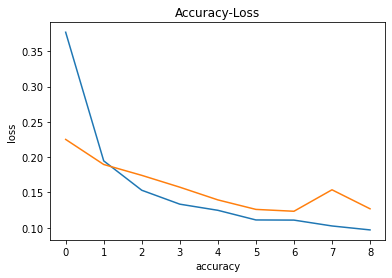

In [ ]:
import matplotlib.pyplot as plt
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', verbose=1),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]

history = model.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=30,callbacks=callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
print(history.history.keys())
plt.title('Accuracy-Loss')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.show()

1/1 [==============================] - 0s 5ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


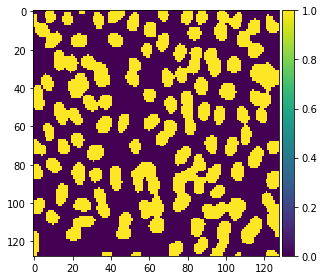

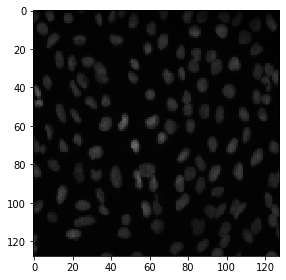

In [ ]:
idx = random.randint(0, len(x_train))
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)

predict = (predict > 0.5).astype(np.uint8)

imshow(np.squeeze(predict[0]))
plt.show()

imshow(x_train[idx])

plt.show()